# 0. Install and Import Dependencies

In [ ]:
!pip list

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import mediapipe as mp
import glob
import graphviz

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [30]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("couldnot find")
    pass

# 1. Build Data Loading Functions

In [3]:

def load_word_images(path: str) -> List[float]:
    frames = []

    with mp.solutions.face_mesh.FaceMesh() as face:
        for image_name in os.listdir(path):
           
            image = imageio.v2.imread(os.path.join(path, image_name))

            if image is not None:        
                results = face.process(image)

                landmarks = results.multi_face_landmarks[0].landmark
                x1, y1 = map(int, (landmarks[0].x * image.shape[1], landmarks[0].y * image.shape[0]))
                x2, y2 = map(int, (landmarks[17].x * image.shape[1], landmarks[17].y * image.shape[0]))

                x = (x1 + x2) // 2 - 70 * 2
                y = (y1 + y2) // 2 - 22 * 3

                cropped_image = image[y:y+135, x:x+280]
                if not (cropped_image.shape[0]>135 and cropped_image.shape[1]>280):
                    pad_height = max(0, 135 - cropped_image.shape[0])
                    pad_width = max(0, 280 - cropped_image.shape[1])
        
                    padded_image = tf.image.pad_to_bounding_box(
                    cropped_image, 0, 0, cropped_image.shape[0] + pad_height, cropped_image.shape[1] + pad_width
                    )
                    frame = tf.image.rgb_to_grayscale(padded_image)
                    frames.append(frame)
                else:
                    frame = tf.image.rgb_to_grayscale(cv2.resize(cropped_image,(280,135)))
                    frames.append(frame)
            else:
                frame = tf.image.rgb_to_grayscale(np.zeros((135, 280, 3), dtype=np.uint8))
                frames.append(frame)

    return tf.cast(tf.image.per_image_standardization(frames), tf.float32)


In [ ]:

# def load_word_images(path: str) -> List[float]:
#     frames = []

#     with mp.solutions.face_mesh.FaceMesh() as face:
#         for image_name in os.listdir(path):
           
#             image = imageio.v2.imread(os.path.join(path, image_name))

#             if image is not None:        
#                 results = face.process(image)

#                 landmarks = results.multi_face_landmarks[0].landmark
#                 x1, y1 = map(int, (landmarks[0].x * image.shape[1], landmarks[0].y * image.shape[0]))
#                 x2, y2 = map(int, (landmarks[17].x * image.shape[1], landmarks[17].y * image.shape[0]))

#                 x = (x1 + x2) // 2 - 70 * 2
#                 y = (y1 + y2) // 2 - 22 * 3

#                 cropped_image = image[y:y+135, x:x+280]

#                 pad_height = max(0, 135 - cropped_image.shape[0])
#                 pad_width = max(0, 280 - cropped_image.shape[1])
#                 try:
#                     padded_image = tf.image.pad_to_bounding_box(
#                     cropped_image, 0, 0, cropped_image.shape[0] + pad_height, cropped_image.shape[1] + pad_width
#                     )
#                     frame = tf.image.rgb_to_grayscale(padded_image)
#                     frames.append(frame)
#                 except:
#                     frame = tf.image.rgb_to_grayscale(cv2.resize(cropped_image,(280,135)))
#                     frames.append(frame)
                    
#             else:
#                 frame = tf.image.rgb_to_grayscale(np.zeros((135, 280, 3), dtype=np.uint8))
#                 frames.append(frame)

#     return tf.cast(tf.image.per_image_standardization(frames), tf.float32)


In [4]:
vocab = ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ',
    'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট',
    'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ',
    'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়',
    'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ', '০', '১', '২', '৩', '৪',
    '৫', '৬', '৭', '৮', '৯','়','া','ি','ী','ু','ূ','ৃ','ে',
    'ৈ','ো','ৌ','্',' '
]

len(vocab)

73

In [5]:
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=vocab,oov_token='', mask_token=None  # Set mask_token to None
)

num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token='', mask_token=None, invert=True,encoding=None
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', ' '] (size =74)


In [ ]:
char_to_num.vocabulary_size()

In [ ]:
char_to_num(vocab)

In [ ]:
char_to_num.get_vocabulary()
char_to_num(['ব','া','ন','ভ'])
num_to_char([34, 62, 31, 35])

output = num_to_char([ 1, 30, 72, 37, 37, 61, 31])

# Convert bytes to strings
output_strings = [char.decode('utf-8') for char in output.numpy()]

print(output_strings)


In [6]:
def load_alignments(path:str) -> List[str]: 
    tokens=path.split('\\')[-1]
    #n_tokens=tokens+tokens
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))#-1 for flattening the latters of word

In [7]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    frames = load_word_images(path) 
    alignments = load_alignments(path)
    
    return frames, alignments

In [ ]:
test_path = r'F:\s1\অধ্যয়ন'

In [ ]:
images=load_word_images(test_path)

In [ ]:
plt.imshow(images[35])

In [ ]:
bytes.decode(tf.convert_to_tensor(test_path).numpy())

In [ ]:
frame, alignment = load_data(tf.convert_to_tensor(test_path))

In [ ]:
alignment

In [ ]:
tf.shape(alignment)

In [ ]:
tf.shape(frame)

In [ ]:
cv2.imshow('img',frame[10].numpy())
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame[39])

In [ ]:
output_strings = [char.decode('utf-8') for char in num_to_char([1, 30, 72, 37, 37, 61, 31]).numpy()]

print(''.join(output_strings))

In [12]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [8]:
folder_paths = glob.glob(os.path.join(r'D:\Dataset\s1', '*'))  #s22 done
len(folder_paths)


503

In [9]:
file_paths=[i for i in folder_paths if len(os.listdir(i))>0 and len(os.listdir(i))<45 ]

In [10]:
len(file_paths)

503

In [13]:

data = tf.data.Dataset.from_tensor_slices(file_paths)
data = data.shuffle(len(file_paths))
data = data.map(mappable_function)
batch_size=1
data = data.padded_batch(batch_size, padded_shapes=([45,None,None,None],[15]))#20 is the optimal value ######[45,None,None,None],[20]
data = data.prefetch(tf.data.AUTOTUNE)


In [14]:
# Added for split 
train = data.take(int(len(file_paths)*.9/batch_size))
test = data.skip(int(len(file_paths)*.9/batch_size))

In [15]:
print(len(train))
len(test)

452


51

In [16]:
frames,alignments=data.as_numpy_iterator().next()

In [ ]:
for element in data.take(len(train)):  # Take the first 5 elements for inspection
    print("Element shapes:")
    print([tf.shape(e) for e in element])


In [ ]:
# frames.shape
# type(sample)
# len(val)
# val[0].shape
# val[0][0].shape

In [17]:
sample = data.as_numpy_iterator()
val = sample.next()

In [ ]:
gif = (val[0][0] * 255).astype(np.uint8).reshape((45, 135, 280))
imageio.mimsave('./animation.gif', gif, fps=10)

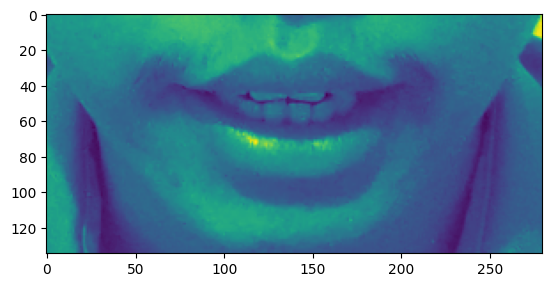

In [18]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][1])

In [ ]:
output_strings = [char.decode('utf-8') for char in num_to_char(val[1][0]).numpy()]

print(''.join(output_strings))

# 3. Design the Deep Neural Network

In [19]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import numpy as np


In [20]:
data.as_numpy_iterator().next()[0].shape

(1, 45, 135, 280, 1)

Transfer Learning

In [ ]:
# pre_model = Sequential()
# pre_model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# pre_model.add(Activation('relu'))
# pre_model.add(MaxPool3D((1,2,2)))

# pre_model.add(Conv3D(256, 3, padding='same'))
# pre_model.add(Activation('relu'))
# pre_model.add(MaxPool3D((1,2,2)))

# pre_model.add(Conv3D(75, 3, padding='same'))
# pre_model.add(Activation('relu'))
# pre_model.add(MaxPool3D((1,2,2)))

# pre_model.add(TimeDistributed(Flatten()))

# pre_model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# pre_model.add(Dropout(.5))

# pre_model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# pre_model.add(Dropout(.5))

# pre_model.add(Dense(41, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
# pre_model.load_weights('E:/Python/Thesis Codes/models/checkpoint')

In [21]:
model = Sequential()
#model.add(Conv3D(128, 3, padding='same'))
model.add(Conv3D(128, 3, input_shape=(45,135,280,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(45, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
# new_input_shape=(45,135,280,1)

In [ ]:
# import numpy as np

# def resize_weights(weights, new_input_shape):
#     # Get the shape of the weights
#     old_input_shape = weights.shape[:-1]  # Exclude the last dimension (output channels)

#     # Resize the weights along the spatial dimensions
#     resized_weights = np.zeros(new_input_shape + (weights.shape[-1],))
#     min_height = min(old_input_shape[0], new_input_shape[0])
#     min_width = min(old_input_shape[1], new_input_shape[1])
#     min_depth = min(old_input_shape[2], new_input_shape[2])
    
#     # Compute the padding dimensions
#     pad_height = new_input_shape[0] - min_height
#     pad_width = new_input_shape[1] - min_width
#     pad_depth = new_input_shape[2] - min_depth
    
#     # Pad the weights if necessary
#     resized_weights[:min_height, :min_width, :min_depth, :] = weights[:min_height, :min_width, :min_depth, :, :]
#     if pad_height > 0:
#         mean_height = np.mean(weights[:min_height, :, :, :, :], axis=0, keepdims=True)
#         resized_weights[min_height:, :, :, :] = np.broadcast_to(mean_height, (pad_height,) + mean_height.shape)
#     if pad_width > 0:
#         mean_width = np.mean(weights[:, :min_width, :, :, :], axis=1, keepdims=True)
#         resized_weights[:, min_width:, :, :] = np.broadcast_to(mean_width, (resized_weights.shape[0], pad_width,) + mean_width.shape)
#     if pad_depth > 0:
#         mean_depth = np.mean(weights[:, :, :min_depth, :, :], axis=2, keepdims=True)
#         resized_weights[:, :, min_depth:, :] = np.broadcast_to(mean_depth, (resized_weights.shape[0], resized_weights.shape[1], pad_depth,) + mean_depth.shape)

#     return resized_weights


In [ ]:


# def resize_dense_weights(weights, new_input_shape):
#     # Get the shape of the weights
#     old_input_shape, output_shape = weights.shape

#     # Calculate the number of input features in the original weights
#     num_input_features = old_input_shape[-1]

#     # Create resized weights with new input shape
#     resized_weights = np.zeros((new_input_shape[0] * new_input_shape[1] * new_input_shape[2], output_shape))

#     # Reshape and copy weights
#     num_features_to_copy = min(num_input_features, resized_weights.shape[0])
#     resized_weights[:num_features_to_copy, :] = weights[:num_features_to_copy, :]

#     return resized_weights



In [ ]:


# # Iterate through layers and copy weights to corresponding layers in your model
# for layer_checkpoint, layer_current in zip(pre_model.layers, model.layers):
#     if layer_current.name.startswith("conv3d"):
#         # Modify weights if the layer is a convolutional layer
#         # Here we resize the weights to match the input shape of the current model
#         weights = layer_checkpoint.get_weights()
#         weights[0] = resize_weights(weights[0], new_input_shape)
#         layer_current.set_weights(weights)
#     elif layer_current.name.startswith("dense"):
#         # Modify weights if the layer is a dense layer
#         # Here we resize the weights to match the input shape of the current model
#         weights = layer_checkpoint.get_weights()
#         weights[0] = resize_dense_weights(weights[0], new_input_shape)
#         layer_current.set_weights(weights)
#     else:
#         # For other layers, simply copy the weights
#         layer_current.set_weights(layer_checkpoint.get_weights())



In [ ]:
plot_model(model, to_file=r'model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 45, 135, 280, 128  3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 45, 135, 280, 128  0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 45, 67, 140, 128)  0        
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 45, 67, 140, 256)  884992    
                                                                 
 activation_1 (Activation)   (None, 45, 67, 140, 256)  0         
                                                        

In [ ]:
# 45*16*35
# yhat = model.predict(val[0])
# # yhat.shape
# # yhat[0][0].shape
# print(tf.argmax(yhat[0],axis=1).numpy())
# output_strings = [char.decode('utf-8') for char in num_to_char(tf.argmax(yhat[0],axis=1)).numpy()]

# print(''.join(output_strings))

In [ ]:
model.input_shape

In [ ]:
model.output_shape

# 4. Setup Training Options and Train

In [28]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [23]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")# for alignment batch
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64") # len of predicted align
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [24]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        ip_len=np.full((yhat.shape[0]),yhat.shape[1])
        decoded = tf.keras.backend.ctc_decode(yhat, ip_len, greedy=False)[0][0].numpy()
        for x in range(len(yhat)): 
            #char.decode('utf-8') for char in num_to_char(tf.argmax(yhat[0],axis=1)).numpy() 
            oos=[char.decode('utf-8') for char in num_to_char(data[1][x]).numpy() if char.decode('utf-8')!='[UNK]']
            oo=''.join(oos)          
            print('Original:', oo)
            pos=[char.decode('utf-8') for char in num_to_char(decoded[x]).numpy() if char.decode('utf-8')!='[UNK]']
            po=''.join(pos)
            print('Prediction:', po)
            print('~'*100)
        

CArefull Here................

In [24]:
model.load_weights('E:\Python\Thesis Codes\models\checkpoint')

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
# Compile the model with custom loss and accuracy as metrics
#model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss, metrics=[CTCLoss, 'accuracy'])


In [26]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [29]:
schedule_callback = LearningRateScheduler(scheduler)

In [30]:
example_callback = ProduceExample(test)

In [28]:
model.load_weights('E:\Python\Thesis Codes\models\checkpoint')

In [31]:
#history = model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])
history = model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback,example_callback])

400/452 [=========================>....] - ETA: 1:13 - loss: 27.0142

DataLossError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "e:\Python\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "e:\Python\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "e:\Python\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "e:\Python\tf\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "e:\Python\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "e:\Python\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Tanvir\AppData\Local\Temp\ipykernel_17252\1971475700.py", line 2, in <module>
      history = model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback,example_callback])
    File "e:\Python\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Python\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "e:\Python\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "e:\Python\tf\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "e:\Python\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "e:\Python\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "e:\Python\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Tanvir\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "e:\Python\tf\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "e:\Python\tf\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "e:\Python\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "e:\Python\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\Python\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Tanvir\AppData\Local\Temp\ipykernel_17252\1971475700.py", line 2, in <module>
      history = model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback,example_callback])
    File "e:\Python\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Python\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "e:\Python\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "e:\Python\tf\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) DATA_LOSS:  Attempted to pad to a smaller size than the input element.
	 [[{{node IteratorGetNext}}]]
	 [[CTCLoss/Shape_3/_4]]
  (1) DATA_LOSS:  Attempted to pad to a smaller size than the input element.
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_14460]

In [ ]:
print(history.history.keys())

In [ ]:
#summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
b=sample[1]
b

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
output_strings = [char.decode('utf-8') for char in num_to_char([32, 31, 63, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]).numpy()]

print(''.join(output_strings))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[45,45], greedy=False)[0][0].numpy()

In [ ]:
a=decoded[0]
a

In [ ]:
print('~'*100, 'PREDICTIONS')
output_strings = [char.decode('utf-8') for char in num_to_char(a).numpy()]

print(''.join(output_strings))

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]